In [1]:
# needed so that build files can be executed in the right directory
import os
if "build" in os.getcwd():
    os.chdir('..')

# Tools

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os
from datetime import timedelta
import webbrowser
import papermill as pm
from enum import Enum
import re
import simplejson as json
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import IsolationForest
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from collections import Counter

In [3]:
# InteractiveShell.ast_node_interactivity = "all"
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json


# Configuration

In [4]:
max_number_of_clusters_kmeans = 30
min_number_of_clusters_kmeans = 2
contamination = 0.02

class OUTLIER_REMOVAL(Enum):
    NONE = 1 
    VARIANCE_THRESHOLD_WITHIN_CLUSTER = 2 
    ISOLATION_FOREST = 3 

outlier_removal = OUTLIER_REMOVAL.ISOLATION_FOREST.value

class CLUSTER_METHOD(Enum):
    KMEANS = 1 
    OPTICS = 2 

cluster_method = CLUSTER_METHOD.OPTICS.value
   
# include_features = ['wei_received', 'wei_sent', 'number_of_tx_received', 'number_of_tx_sent', 'mined_blocks', 'contract_tx']
# include_features = ['wei_received', 'wei_sent', 'number_of_tx_received',
#        'number_of_tx_sent',
#         'mined_blocks', 'active_months', 'usd_received', 'usd_sent', 'number_of_contracts_created', 'contract_tx',
#        'diff_token_used']
# include_features = ['wei_received', 'wei_sent', 'balance', 'number_of_tx_received',
#        'number_of_tx_sent',
#         'mined_blocks', 'active_months', 'usd_received', 'usd_sent',
#        'avg_wei_sent', 'avg_wei_received', 'avg_usd_sent', 'avg_usd_received',
#        'monthly_wei_sent', 'monthly_wei_received', 'monthly_usd_sent',
#        'monthly_usd_received', 'monthly_outgoing_txns',
#        'monthly_incoming_txns', 'number_of_contracts_created', 'contract_tx',
#        'diff_token_used']
# include_features = ['wei_received', 'wei_sent', 'balance', 'number_of_tx_received',
#        'number_of_tx_sent', 'avg_time_diff_received_tx',
#        'avg_time_diff_sent_tx', 'mined_blocks', 'stddev_received_tx',
#        'stddev_sent_tx', 'active_months', 'usd_received', 'usd_sent',
#        'avg_wei_sent', 'avg_wei_received', 'avg_usd_sent', 'avg_usd_received',
#        'monthly_wei_sent', 'monthly_wei_received', 'monthly_usd_sent',
#        'monthly_usd_received', 'monthly_outgoing_txns',
#        'monthly_incoming_txns', 'number_of_contracts_created', 'contract_tx',
#        'diff_token_used']
include_features = "all"
    
reset_clustering_result = True

In [5]:
number_of_addresses = 10000

# format: yyyy-mm-dd
observation_period_start = "2019-06-01 00:00:00+00" 
observation_period_end = "2020-01-01 00:00:00+00"

class ADDRESS_SELECTION(Enum):
    RANDOM = 1 # selects random features.index, that have been active within the observation period.
    RICHEST = 2 # selects the accounts that have the most ether # not yet implemented
    HIGHEST_TURNOVER = 3 # selects the accounts that have the most ether received + sent

address_selection = ADDRESS_SELECTION.HIGHEST_TURNOVER.value

# max USD amount to spent for executing sql queries
max_bigquery_costs_usd = 2

# Delete existing tables
reset_feature_tables = False

# Create feature table in bigquery

In [6]:
# todo: eindeutige id in form von einem hash welcher auch die attribute umfasst
table_name = "features"
table_id = "{}_{}_{}_{}_{}".format(table_name, ADDRESS_SELECTION(address_selection).name, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end))

In [7]:
try:
    pm.execute_notebook(
       './features/features.ipynb',
       './build/{}.build.ipynb'.format(table_id),
       parameters = dict(number_of_addresses=number_of_addresses, observation_period_start=observation_period_start,observation_period_end=observation_period_end, address_selection=address_selection,max_bigquery_costs_usd=max_bigquery_costs_usd, reset = reset_feature_tables),
       cwd = "./features"
    )
except Exception as e:
    if "does already exist" in e.args[0]:
        print("Feature table does already exist.")
        pass
    else:
        raise


Feature table does already exist.


# Load feature table from bigquery

In [8]:
filename = '{}.json'.format(table_id)
data_dir = "./data"

if filename not in os.listdir("./data") or reset_feature_tables == True:
     
    print("Loading data from bigquery ...")
    
    sql = """
        SELECT *
        FROM `masterarbeit-245718.ethereum_us.{table_id_features}` 
        """.format(table_id_features = table_id)

    query_job = client.query(sql)  
    
    start = time.time();
    
    features = query_job.result().to_dataframe(); 
    features = features.set_index("address")
    
    done = time.time();
    elapsed = round(done - start);
    
    print("Time to retrieve data from BigQuery: {} Minutes.".format(round(elapsed/60)))
    
    with open('{}/{}'.format(data_dir, filename), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
        
else: 
    
    print("Loading data from local cache ...")
    
    start = time.time();
    
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
        
    done = time.time();
    elapsed = round(done - start);
    
    features = pd.DataFrame(file_content_json) 
    
    print("Time to retrieve data from local cache: {} Seconds.".format(elapsed))
        
features = features.dropna()

Loading data from local cache ...
Time to retrieve data from local cache: 0 Seconds.


In [9]:
m = features.memory_usage();
total_bytes = m.sum();
total_megabytes = total_bytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(total_megabytes)))

Size of the account feature dataset: 2.0 Megabytes.


# Set avg_time_diff and stddev 0 values to max

In [10]:
features = features[features["avg_time_diff_sent_tx"] != 0]

In [11]:
# features["avg_time_diff_sent_tx"] = features["avg_time_diff_sent_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_sent_tx"]))
# features["avg_time_diff_received_tx"] = features["avg_time_diff_received_tx"].replace(to_replace=0.0, value=max(features["avg_time_diff_received_tx"]))

In [12]:
# features["stddev_received_tx"] = features["stddev_received_tx"].replace(to_replace=0.0, value=max(features["stddev_received_tx"]))
# features["stddev_sent_tx"] = features["stddev_sent_tx"].replace(to_replace=0.0, value=max(features["stddev_sent_tx"]))

# Exclude features

In [13]:
if include_features == "all":
    include_features = ['wei_received', 'wei_sent', 'balance', 'number_of_tx_received',
       'number_of_tx_sent', 'avg_time_diff_received_tx',
       'avg_time_diff_sent_tx', 'mined_blocks', 'stddev_received_tx',
       'stddev_sent_tx', 'active_months', 'usd_received', 'usd_sent',
       'avg_wei_sent', 'avg_wei_received', 'avg_usd_sent', 'avg_usd_received',
       'monthly_wei_sent', 'monthly_wei_received', 'monthly_usd_sent',
       'monthly_usd_received', 'monthly_outgoing_txns',
       'monthly_incoming_txns', 'number_of_contracts_created', 'contract_tx',
       'diff_token_used']
        
features = features[include_features]

# Standardise feature values, so that all feature values have the same mean and stddev

In [14]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
features_std = scaler.fit_transform(features);
features_std = pd.DataFrame(features_std, columns=features.columns, index=features.index);

# Plot the three principal component attribut values with outliers

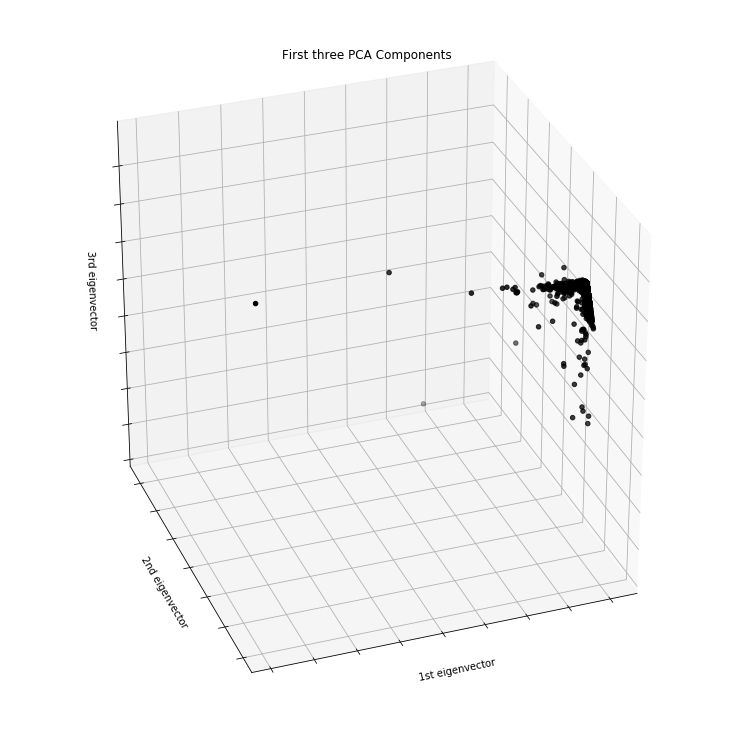

In [15]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 

ax.scatter(features_std_pca_tmp["1st eigenvector"], 
           features_std_pca_tmp["2st eigenvector"],
           features_std_pca_tmp["3st eigenvector"], c="black");

ax.set_title("First three PCA Components");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);

# Use Isolationforest to identify outliers

In [16]:
clf = IsolationForest(max_samples="auto", behaviour='new', contamination=0.01)

clf.fit(features_std)
pred = clf.predict(features_std)

features_clean = features[pred == 1]
features_std_clean = features_std[pred == 1]

outliers = features[pred == -1]

print("Number of detected outliers: {}".format(outliers.shape[0]))

Number of detected outliers: 84


In [17]:
# Display outliers
outliers_tmp = outliers.copy()
outliers_tmp["turnover"] = outliers["wei_received"] + outliers["wei_sent"]
outliers_tmp = outliers_tmp.sort_values(by=["turnover"], ascending=False)
outliers_tmp.head(100)

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,turnover
0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,17198743185703589029081791,17117294026529545432348298,81449159174043596733493,724880,480131,2.550554e+01,3.850928e+01,0,1.534869e+02,1.145612e+02,...,2.44533e+24,2.45696e+24,5.077694e+08,5.097466e+08,6.859014e+04,103554.285714,0,317155,122,34316037212233134461430089
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,7185636033112714484322771,6503167334760452922982501,682468698352261561340270,3853832,358400,4.797698e+00,5.158812e+01,0,1.617549e+01,9.510700e+01,...,9.29024e+23,1026519433301816354903253,1.710350e+08,1.826999e+08,5.120000e+04,550547.428571,0,0,1,13688803367873167407305272
0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,5584183598257985368124640,5867677762000000000000000,-283494163742014631875360,153607,460491,1.147539e+02,4.015135e+01,0,1.107479e+04,1.089046e+02,...,8.3824e+23,7.97741e+23,1.925297e+08,1.845616e+08,6.578443e+04,21943.857143,0,449764,369,11451861360257985368124640
0x5e032243d507c743b061ef021e2ec7fcc6d3ab89,4248915115389995318482829,4299720909969814553442786,-50805794579819234959957,283376,210033,6.415535e+01,7.381898e+01,0,3.715381e+03,1.939714e+02,...,6.14246e+23,6.06988e+23,1.347024e+08,1.347066e+08,3.000471e+04,40482.285714,0,2,1,8548636025359809871925615
0x876eabf441b2ee5b5b0554fd502a8e0600950cfa,4283216581661081039674815,4236039777146300000000000,47176804514781039674815,79018,86106,2.339709e+02,2.146998e+02,0,3.329833e+02,3.825460e+02,...,6.05149e+23,6.11888e+23,1.340177e+08,1.349635e+08,1.230086e+04,11288.285714,0,44230,120,8519256358807381039674815
0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,3868730536783775039068891,4250896805463919800000000,-382166268680144760931109,176112,87022,1.049869e+02,2.124618e+02,0,1.459638e+02,3.190265e+02,...,607270972209131400000000,5.52676e+23,1.258167e+08,1.123773e+08,1.243171e+04,25158.857143,0,0,0,8119627342247694839068891
0xfa52274dd61e1643d2205169732f29114bc240b3,3868724606334355122823040,3868724606334355122823040,0,176092,176092,1.049988e+02,1.049988e+02,0,1.459817e+02,1.459817e+02,...,5.52675e+23,5.52675e+23,1.123772e+08,1.123772e+08,2.515600e+04,25156.000000,0,0,0,7737449212668710245646080
0x0681d8db095565fe8a346fa0277bffde9c0edbbf,3811773248376168907543830,3798894956478730000000000,12878291897438907543830,522,410957,3.539654e+04,4.499134e+01,0,3.139619e+04,1.278565e+02,...,5.42699e+23,5.44539e+23,1.128378e+08,1.132472e+08,5.870814e+04,74.571429,0,256583,112,7610668204854898907543830
0x564286362092d8e7936f0549571a803b203aaced,3772117193726925634204226,3763210880226730000000000,8906313500195634204226,499,416111,3.696888e+04,4.443408e+01,0,3.148146e+04,1.264220e+02,...,5.37602e+23,5.38874e+23,1.110708e+08,1.113345e+08,5.944443e+04,71.285714,0,261847,115,7535328073953655634204226
0xd551234ae421e3bcba99a0da6d736074f22192ff,3761593529386064657481952,3744338207738580000000000,17255321647484657481952,500,406939,3.700873e+04,4.543583e+01,0,3.253983e+04,2.735599e+02,...,5.34905e+23,537370504198009236783136,1.109682e+08,1.114442e+08,5.813414e+04,71.428571,0,255471,113,7505931737124644657481952


In [18]:
filename_outliers = "outliers_{}_{}_{}_{}_{}_{}_{}.json".format(address_selection, outlier_removal, cluster_method, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end), hash(str(include_features)))
with open('{}/{}'.format(data_dir, filename_outliers), 'w') as json_file:
    json.dump(features.to_dict(), json_file, use_decimal=True, default=str)

In [19]:
# # opens outliers features.index via etherscan
# n = 5 # first n features.index get opened
# i = 0
# for address, features in outliers_tmp.iterrows():
#     webbrowser.open('https://etherscan.io/address/{}'.format(address), new=2)
#     i += 1
#     if i == n:
#         break

# Use Isolationforest to remove outliers

In [20]:
if outlier_removal == OUTLIER_REMOVAL.ISOLATION_FOREST.value:
    features = features_clean
    features_std = features_std_clean

# Plot the three principal component values without outliers

In [21]:
if outlier_removal == OUTLIER_REMOVAL.ISOLATION_FOREST.value:
    from mpl_toolkits.mplot3d import Axes3D;
    
    fig = plt.figure(figsize=(10, 10));
    ax = Axes3D(fig, elev=-150, azim=110);
    
    pca_tmp = PCA(n_components=3)
    features_std_clean_pca_tmp = pca_tmp.fit_transform(features_std_clean);
    features_std_clean_pca_tmp = pd.DataFrame(features_std_clean_pca_tmp)
    features_std_clean_pca_tmp.index = features.index 
    features_std_clean_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 
    
    ax.scatter(features_std_clean_pca_tmp["1st eigenvector"], 
               features_std_clean_pca_tmp["2st eigenvector"],
               features_std_clean_pca_tmp["3st eigenvector"], c="black");
    
    ax.set_title("First three PCA Components");
    ax.set_xlabel("1st eigenvector");
    ax.w_xaxis.set_ticklabels([]);
    ax.set_ylabel("2nd eigenvector");
    ax.w_yaxis.set_ticklabels([]);
    ax.set_zlabel("3rd eigenvector");
    ax.w_zaxis.set_ticklabels([]);

# Dimension Reduction via Principal Component Analysis

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [22]:
min_explained_variance = 0.9

In [23]:
pca = PCA().fit(features_std)
optimal_number_of_clusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimal_number_of_clusters = optimal_number_of_clusters + 1
    if i > min_explained_variance:
        break;

print("Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimal_number_of_clusters, min_explained_variance*100))

Die 11 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.


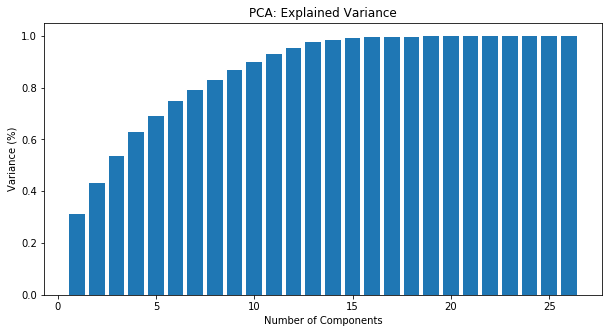

In [24]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()

In [25]:
pca = PCA(n_components=optimal_number_of_clusters);
features_std_pca = pca.fit_transform(features_std);
features_std_pca = pd.DataFrame(features_std_pca);
features_std_pca.index = features.index
features_std_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0x0000000000c90bc353314b6911180ed7e06019a9,1.027445,2.774006,-0.148754,0.278802,1.747237,2.365525,1.016947,0.116948,-1.253469,0.662923,-0.357450
0x00000000af5a61acaf76190794e3fdf1289288a1,1.806626,2.422133,-0.419726,0.311579,1.783763,2.925259,6.101066,-2.295970,6.581312,-2.558083,0.520278
0x000000aaee6a496aaf7b7452518781786313400f,-0.080252,0.533376,-0.937807,0.453287,0.071154,0.106992,1.114336,0.573265,-0.539108,-0.094099,0.161268
0x00032044a1e2f6a4541d9e3c1fa31227efc31ead,-0.442472,0.239389,-0.483651,0.033642,-0.013403,-0.043241,0.284627,0.297392,-0.255356,-0.405567,-0.198094
0x00041cf9bbf3aac338c59b77c0f559ffbc4703d0,0.224186,0.154376,-0.651009,0.671696,-0.184779,-0.187476,-0.664174,-0.572754,0.449436,0.533181,0.262361


# Caluclate number of clusters via Clinski Harabasz Score (only when using K-MEANS)

In [26]:
def estimateNumberOfClusters(features, features_std_pca, max_number_of_clusters_kmeans):
    scores = []
    numberOfCluster = []

    for i in range(2,max_number_of_clusters_kmeans,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimal_number_of_clusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimal_number_of_clusters;

In [27]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [28]:
if cluster_method == CLUSTER_METHOD.KMEANS.value:
    scores = []
    numberOfCluster = []
    
    # 3 clusters are not considered to be valid
    for i in range(min_number_of_clusters_kmeans, max_number_of_clusters_kmeans, 1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
    optimal_number_of_clusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

In [29]:
if cluster_method == CLUSTER_METHOD.KMEANS.value:
    plt.figure(figsize=(10,5))
    bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
    plt.xlabel(results.columns[0])
    plt.ylabel(results.columns[1]) 
    bars[results["calinski_score"].idxmax()].set_color("r")
    plt.show()
    plt.close()
    print("The optimal number of clusters is {}.".format(optimal_number_of_clusters))

# Clustering

In [30]:
filename_features = "clusteranalysis_features_{}_{}_{}_{}_{}_{}_{}.json".format(address_selection, outlier_removal, cluster_method, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end), hash(str(include_features)))
filename_features_std = "clusteranalysis_features_std_{}_{}_{}_{}_{}_{}_{}.json".format(address_selection, outlier_removal, cluster_method, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end), hash(str(include_features)))
filename_features_std_pca = "clusteranalysis_features_std_pca_{}_{}_{}_{}_{}_{}_{}.json".format(address_selection, outlier_removal, cluster_method, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end), hash(str(include_features)))        

if cluster_method == CLUSTER_METHOD.KMEANS.value:
    cluster_model = KMeans(n_clusters=optimal_number_of_clusters)

if cluster_method == CLUSTER_METHOD.OPTICS.value:
    cluster_model = OPTICS(metric="cosine")
#     cluster_model = OPTICS(min_cluster_size=30)
    
    
if filename_features not in os.listdir("./data") or filename_features_std not in os.listdir(data_dir) or filename_features_std_pca not in os.listdir(data_dir) or reset_clustering_result == True:
     
    print("Clustering data ...")
    start = time.time();

    cluster_model.fit(features_std_pca)
    
    features["label"] = cluster_model.labels_
    
    if cluster_method == CLUSTER_METHOD.OPTICS.value:
        features["reachability"] = cluster_model.reachability_
        features["core_distances"] = cluster_model.core_distances_
        features["ordering"] = cluster_model.ordering_
            
    # save clustering results in order to save time in the next run
    with open('{}/{}'.format(data_dir, filename_features), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
    with open('{}/{}'.format(data_dir, filename_features_std), 'w') as json_file:
        json.dump(features_std.to_dict(), json_file, use_decimal=True, default=str)
    with open('{}/{}'.format(data_dir, filename_features_std_pca), 'w') as json_file:
        json.dump(features_std_pca.to_dict(), json_file, use_decimal=True, default=str) 
        
    done = time.time();
    elapsed = round(done - start);
    print("Done. Time to cluster data: {} Minutes.".format(round(elapsed/60)))
    
else:
    
    print("Loading data from local cache.")
    
    start = time.time();
    
    with open('./data/{}'.format(filename_features), "r") as file:  
        file_content_json = json.load(file);
    features = pd.DataFrame(file_content_json) 
    
    with open('./data/{}'.format(filename_features_std), "r") as file:  
        file_content_json = json.load(file);
    features_std = pd.DataFrame(file_content_json) 
    
    with open('./data/{}'.format(filename_features_std_pca), "r") as file:  
        file_content_json = json.load(file);
    features_std_pca = pd.DataFrame(file_content_json)     
    
    cluster_model.labels_ = features["label"].reset_index(drop=True)
    
    if cluster_method == CLUSTER_METHOD.OPTICS.value:
        cluster_model.reachability_ = features["reachability"].reset_index(drop=True)
        cluster_model.core_distances_ = features["core_distances"].reset_index(drop=True)
        cluster_model.ordering_ = features["ordering"].reset_index(drop=True)

    print("Done.")

if cluster_method == CLUSTER_METHOD.OPTICS.value:
    features = features.drop(columns=["reachability"])
    features = features.drop(columns=["core_distances"])
    features = features.drop(columns=["ordering"])

Clustering data ...
Done. Time to cluster data: 1 Minutes.


In [31]:
print("Number of Clusters {}".format(len(features["label"].unique())))

Number of Clusters 293


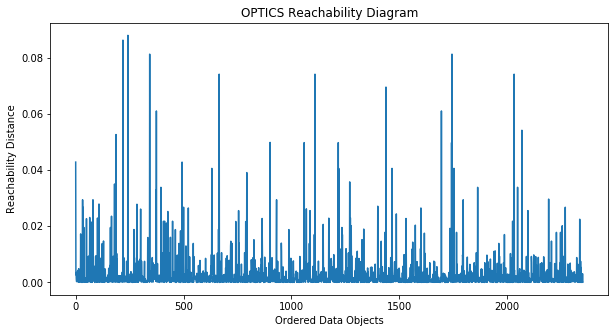

In [32]:
if cluster_method == CLUSTER_METHOD.OPTICS.value:
    plt.figure(figsize=(10,5))
    plt.xlabel('Ordered Data Objects')
    plt.ylabel('Reachability Distance') #for each component
    plt.title('OPTICS Reachability Diagram')
    plt.plot(cluster_model.reachability_[cluster_model.labels_ != -1])

# tmp

In [33]:
# cluster_model.labels_ = cluster_optics_dbscan(reachability=cluster_model.reachability_,
#                                    core_distances=cluster_model.core_distances_,
#                                    ordering=cluster_model.ordering_, eps=0.0007)
# features["label"] = cluster_model.labels_


# features_clean[features_clean["label"] == 45].index

# Remove outliers for OPTICS

In [34]:
len(features[features.label == -1])

6004

In [35]:
labels = pd.Series(data=cluster_model.labels_, index=features.index)

features_clean = features[labels != -1]
features_std_clean = features_std[labels != -1]
features_std_pca_clean = features_std_pca[labels != -1]
# features_clean = features
# features_std_clean = features_std
# features_std_pca_clean = features_std_pca

# Remove outliers for each cluster via variance threshold

In [36]:
def remove_outliers(features, cluster_model, threshold):
    
    features_without_outliers = pd.DataFrame()
    labels_without_outliers = []

    for label in np.unique(cluster_model.labels_):
        centroid = np.array(features_std_pca[cluster_model.labels_ == label].mean())

        features_within_cluster = features[cluster_model.labels_ == label];
        # distance of each point in cluster to cluster's centroid
        distances = features_within_cluster - centroid;
        # convert to scalar
        distances_norm = np.linalg.norm(distances, axis=1);
        # max_distance for this cluster
        max_distance = threshold * np.linalg.norm(features_within_cluster.std())
        
        keep = distances_norm <= max_distance
        
        features_without_outliers = features_without_outliers.append(features_within_cluster[keep])
        labels_without_outliers.extend([label for i in features_within_cluster[keep].iterrows()])
        
    features_without_outliers["label"] = labels_without_outliers
    return features_without_outliers

In [37]:
if outlier_removal == OUTLIER_REMOVAL.VARIANCE_THRESHOLD_WITHIN_CLUSTER.value:
    from sklearn.metrics import calinski_harabaz_score as ch_score
    
    thresholds = np.linspace(.0001,.6, 20)
    
    features_tables_without_outliers = [remove_outliers(features_std_pca_clean, cluster_model, t) for t in thresholds]
    
    scores= []
    res = []
    
    for f,t in zip(features_tables_without_outliers, thresholds):
        if not f.empty and len(f["label"].unique()) > 1 and len(f) > 4:
            scores.append((metrics.calinski_harabasz_score(f.drop(columns=["label"]), f["label"]), t))
            res.append(f)
            
    scores = [x for x in zip(*scores)]
    
    plt.plot(scores[1], scores[0])
    plt.title('Calinski Harabaz Scores as std threshold changes')    
    
    optimal_threshold = thresholds[np.argmax(scores)]
    features_std_pca_without_outliers = res[np.argmax(scores)]
    features = features_clean.reindex(features_std_pca_without_outliers.index)
    features_std = features_std_clean.reindex(features_std_pca_without_outliers.index)
    features_std_pca = features_std_pca_clean.reindex(features_std_pca_without_outliers.index)  
    
    print("The threshold leading to the highest Calinski Harabaz Score is", optimal_threshold)

# Visualisierung: T-SNE

In [38]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# features_std_pca_out_tsne = tsne.fit_transform(features_std_pca_out)
# features_std_pca_out_tsne = pd.DataFrame(features_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# features_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [39]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# features_std_pca_out_tsne["Label"] = cluster_model.labels_
# features_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=features_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

## Display principal components

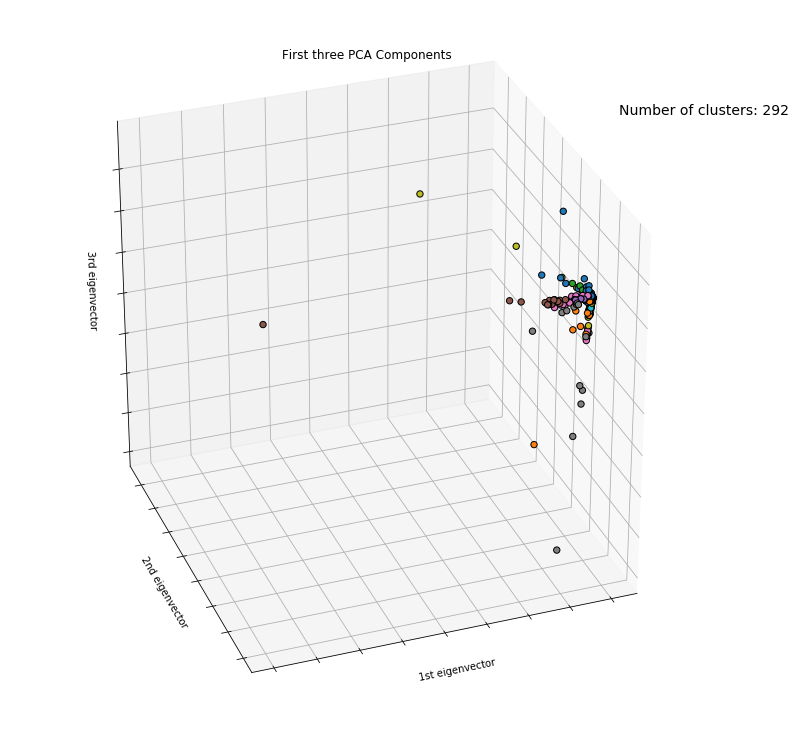

In [40]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std_clean);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features_clean.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 
features_std_pca_tmp["label"] = features_clean["label"]

labels = np.sort(features_std_pca_tmp.label.unique())

for l in labels:
    ax.scatter(features_std_pca_tmp["1st eigenvector"][features_std_pca_tmp["label"] == l], 
           features_std_pca_tmp["2st eigenvector"][features_std_pca_tmp["label"] == l],
           features_std_pca_tmp["3st eigenvector"][features_std_pca_tmp["label"] == l],
           label = l, 
           edgecolor='k', s=40, alpha = 1);

ax.set_title("First three PCA Components");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);

number_of_clusters = len(features_clean["label"].unique())
if number_of_clusters < 50:
    ax.legend(title= "Clusters")
else:
    ax.annotate("Number of clusters: {}".format(number_of_clusters), xy=(0.85,0.85), xycoords='axes fraction',
             fontsize=14)

# Display cluster means 

In [41]:
clusters = dict() 
labels = features_clean["label"].unique()
labels.sort()

for label in labels:
    cluster_name = 'cluster_{}'.format(label)
    
    features_in_cluster = features_clean[features_clean.label == label]
    
    clusters[cluster_name] = dict()
    clusters[cluster_name]["number_of_addresses"] = Counter(features_clean["label"])[label]
    clusters[cluster_name]["feature_means"] = features_in_cluster.drop(columns=["label"]).mean()
    
feature_means = pd.DataFrame(columns = clusters[cluster_name]['feature_means'].keys())

for key in clusters:
    clusters[key]["feature_means"].name = key
    feature_means = feature_means.append(clusters[key]["feature_means"])

In [42]:
feature_means_display = feature_means.round()

if "wei_received" in feature_means_display.columns:
    feature_means_display["eth_received"] = feature_means_display["wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["wei_received"])

if "wei_sent" in feature_means_display.columns:
    feature_means_display["eth_sent"] = feature_means_display["wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["wei_sent"])

    
if "balance" in feature_means_display.columns:
    feature_means_display["eth_balance"] = feature_means_display["balance"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["balance"])
    
if "avg_wei_sent" in feature_means_display.columns:
    feature_means_display["avg_eth_sent"] = feature_means_display["avg_wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["avg_wei_sent"])
    
if "avg_wei_received" in feature_means_display.columns:
    feature_means_display["avg_eth_received"] = feature_means_display["avg_wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["avg_wei_received"])
    
if "monthly_wei_sent" in feature_means_display.columns:
    feature_means_display["monthly_eth_sent"] = feature_means_display["monthly_wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["monthly_wei_sent"])
    
if "monthly_wei_received" in feature_means_display.columns:
    feature_means_display["monthly_eth_received"] = feature_means_display["monthly_wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["monthly_wei_received"])
    
feature_means_display["number_of_addresses"] = [clusters[c]["number_of_addresses"] for c in clusters]

if set(["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]).issubset(set(feature_means_display.columns)):
    cols = list(feature_means_display.columns.values) 
    cols.pop(cols.index('number_of_addresses')) 
    cols.pop(cols.index('eth_balance')) 
    cols.pop(cols.index('eth_sent')) 
    cols.pop(cols.index('eth_received')) 
    feature_means_display = feature_means_display[["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]+cols] 


if len(feature_means_display.columns) > len(feature_means_display.index):
    print("Number of Addresses: {}".format(number_of_addresses))
    print("Observation-Period: {} to {}".format(observation_period_start, observation_period_end))
    display(feature_means_display.sort_values(by="number_of_addresses", ascending=False).T.astype("int"))
else:
    display(feature_means_display.astype("int").sort_values(by="number_of_addresses", ascending=False))

,number_of_addresses,eth_balance,eth_sent,eth_received,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,...,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,avg_eth_sent,avg_eth_received,monthly_eth_sent,monthly_eth_received
cluster_83,27,-279,5142,4863,8,8,1909813,1912475,0,2587731,...,244910,2,2,0,2,1,641,648,1285,1215
cluster_137,21,72,12262,12335,2669,14631,33883,6347,0,67523,...,358992,2124,385,0,9514,196,3,24,1784,1795
cluster_18,20,5,5557,5563,287,322,79641,72695,0,187357,...,162896,46,41,0,77,1,23,26,793,794
cluster_213,19,-6619,6619,0,0,3,21,19273,0,0,...,12,3,0,0,0,0,2272,0,6619,0
cluster_37,19,-10,5047,5036,70,67,266444,278324,0,451232,...,150312,10,10,0,13,1,76,77,721,719
cluster_46,19,-20,3904,3884,38,53,448816,371518,0,627077,...,111455,8,5,0,18,2,86,119,557,554
cluster_126,17,-31,4076,4045,4,4,1778860,2216548,0,862316,...,450536,2,2,0,1,0,1196,1489,2038,2022
cluster_175,17,45,3428,3474,484,587,3636,5255,0,12009,...,354658,294,242,0,125,0,11,7,1714,1737
cluster_134,17,2,5046,5049,38,35,466419,487555,0,998097,...,221249,7,8,0,1,0,173,167,1009,1009
cluster_145,16,3408,3040519,3043927,112350,124921,1571,266,0,16293,...,106234889,21457,17548,0,24751,8,36,186,485363,485647


In [43]:
df_tmp = feature_means_display.sort_values(by="number_of_addresses", ascending=False).T.astype("int")
df_tmp.to_csv(r"./tmp.csv")
df_tmp

,cluster_83,cluster_137,cluster_18,cluster_213,cluster_37,cluster_46,cluster_126,cluster_175,cluster_134,cluster_145,...,cluster_118,cluster_246,cluster_36,cluster_253,cluster_28,cluster_255,cluster_26,cluster_257,cluster_170,cluster_69
number_of_addresses,27,21,20,19,19,19,17,17,17,16,...,5,5,5,5,5,5,5,5,5,5
eth_balance,-279,72,5,-6619,-10,-20,-31,45,2,3408,...,-63,0,36,0,5,0,52,0,0,271
eth_sent,5142,12262,5557,6619,5047,3904,4076,3428,5046,3040519,...,20732,12192,11235,3685,3616,5424,4241,3684,4355,81322
eth_received,4863,12335,5563,0,5036,3884,4045,3474,5049,3043927,...,20668,12192,11271,3685,3621,5424,4294,3684,4355,81594
number_of_tx_received,8,2669,287,0,70,38,4,484,38,112350,...,894,5,109,65,503,74,91,226,58,345
number_of_tx_sent,8,14631,322,3,67,53,4,587,35,124921,...,390,5,144,53,1720,77,89,233,33,353
avg_time_diff_received_tx,1909813,33883,79641,21,266444,448816,1778860,3636,466419,1571,...,37907,1093816,161407,153371,36806,160287,197811,55899,81630,59844
avg_time_diff_sent_tx,1912475,6347,72695,19273,278324,371518,2216548,5255,487555,266,...,55640,1093740,139661,214750,12650,151718,215098,56611,111838,54300
mined_blocks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
stddev_received_tx,2587731,67523,187357,0,451232,627077,862316,12009,998097,16293,...,60472,695770,261112,240798,69900,250704,336036,66190,203636,150352


In [44]:
feature_means_display[feature_means_display.mined_blocks>0]

,number_of_addresses,eth_balance,eth_sent,eth_received,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,...,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,avg_eth_sent,avg_eth_received,monthly_eth_sent,monthly_eth_received
cluster_243,9,-136.829242,4933.484528,4796.655286,2418.0,4007.0,8537.0,11568.0,2415.0,23309.0,...,139664.0,572.0,345.0,0.0,0.0,0.0,2.603025,1.986902,704.783504,685.236469
cluster_282,9,-1541.683415,32492.609496,30950.926081,15393.0,23097.0,1282.0,18733.0,15381.0,1582.0,...,903677.0,3300.0,2199.0,0.0,3.0,0.0,42.216951,2.005554,4641.801357,4421.560869


In [45]:
# feature_means_display.astype("int").sort_values(by="number_of_addresses", ascending=False).loc[["cluster_0", "cluster_1", "cluster_8"]].T

In [46]:
# feature_means_display[feature_means_display.contract_tx > 0]

In [47]:
# i = 0
# for index, row in features[features.label == 3].iterrows():
#     i += 1
#     a = row.name
#     webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
#     if i == 5:
#         break

In [48]:
feature_means_display.idxmax()

number_of_addresses             cluster_83
eth_balance                    cluster_291
eth_sent                       cluster_145
eth_received                   cluster_145
number_of_tx_received            cluster_2
number_of_tx_sent              cluster_288
avg_time_diff_received_tx      cluster_273
avg_time_diff_sent_tx           cluster_93
mined_blocks                   cluster_282
stddev_received_tx              cluster_76
stddev_sent_tx                 cluster_122
active_months                    cluster_0
usd_received                   cluster_145
usd_sent                       cluster_145
avg_usd_sent                   cluster_281
avg_usd_received               cluster_277
monthly_usd_sent               cluster_145
monthly_usd_received           cluster_145
monthly_outgoing_txns          cluster_288
monthly_incoming_txns            cluster_2
number_of_contracts_created    cluster_290
contract_tx                    cluster_288
diff_token_used                cluster_286
avg_eth_sen

In [49]:
# s = features_std_pca_clean.idxmax()
# for i in s:
#     print(i, features_clean.loc[i,:].label)
#     label = features_clean.loc[i,:].label
#     display(feature_means_display.astype("int").loc["cluster_{}".format(label)])
# # snowflakes
# # for i in snowflakes:
# #     print(features.index[i])

In [50]:
features_clean[features_clean.label == 89].sort_values(by="mined_blocks", ascending=False)

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,label
0x32cb90b69da0d2c675b97d0284db65a7203e03da,2541244127220000000000,2540987625631789926218,256501588210073782,2,10,8122963.0,1.497926e+06,0,0.000000e+00,2.182679e+06,...,6.35247e+20,635311031805000000000,97530.224524,97910.088431,2.50,0.50,0,8,1,89
0x4855c2da265c54a6fc5ccf1b7c5b1c1b6645f37b,3838585545000000000000,3838582455448000000000,3089552000000000,6,10,2730914.4,1.385044e+06,0,4.511208e+06,2.591819e+06,...,959645613862000000000,959646386250000000000,146303.978311,146297.408742,2.50,1.50,0,7,1,89
0x54797731653b9802e635898d17454adeb7a7248d,4000100000000000000000,4000096291016492000000,3708983508000000,4,9,2470834.0,1.910949e+06,0,4.219445e+06,2.513701e+06,...,1000024072754123000000,1000025000000000000000,260863.486880,260867.913250,2.25,1.00,0,5,2,89
0x570bbfa5d7bc4a81dcc39361e119ede920c719fe,2000000000000000000911,3000010000000000000000,-1000009999999999999089,3,7,4058054.5,1.415663e+06,0,2.696791e+06,2.357149e+06,...,750002500000000000000,5e+20,145160.440975,90492.500000,1.75,0.75,0,0,0,89
0xa2e293fbc6646ae3e0ecba0cb84efdd6125911b9,2736506100985000000000,2736498216925000000000,7884060000000000,6,5,2792386.8,3.369850e+06,0,5.732929e+06,2.029326e+06,...,684124554231250000000,684126525246250000000,133654.317731,164683.806999,1.25,1.50,0,3,1,89
0xa6bfbb9a4116c28cbf4c558a725f6001592e661c,4000000000000000000000,3999990862800000000000,9137200000000000,6,10,1729318.0,1.122048e+06,0,3.145009e+06,2.139014e+06,...,999997715700000000000,1000000000000000000000,206840.764734,205556.750000,2.50,1.50,0,6,1,89


In [51]:
# fig, ax = plt.subplots(figsize= (20,10))

# scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
# features_std = scaler.fit_transform(features);
# features_std = pd.DataFrame(features_std, columns=features.columns);
# X_reduced = PCA(n_components=2).fit_transform(features_std);

# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_model.labels_)
# ax.set_xlabel("Principal Component 1")
# ax.set_ylabel("Principal Component 2")
# pd.Series(cluster_model.labels_).unique()

In [52]:
# features_std_pca_tmp.idxmax()

In [53]:
# snowflakes = features_std_pca_tmp.idxmax()
# snowflakes
# for i in snowflakes:
#     print(features.index[i])

# Display Cluster means with standardised features via radar plots

In [54]:
# cluster_data_for_plot1 = cluster_data.drop(columns=["cluster_size"])
# cluster_data_for_plot1 = cluster_data_for_plot1 / cluster_data_for_plot1.sum()
# cluster_data_for_plot1["cluster_size"] = cluster_data["cluster_size"]
# # cluster_data_for_plot1 = cluster_data_for_plot1.reset_index()

# ax = cluster_data_for_plot1.plot.barh(x="cluster_size" ,figsize=(15,15))

# ax.tick_params(
#     which="major",
#     axis='x', 
#     bottom=False
#     )

# ax.tick_params(
#     which="major",
#     axis='y', 
#     labelsize=15
#     ) 

# ylabels = ax.get_yticklabels()

# ax.legend(loc="lower right", fontsize="larger")

# ax.set_xticklabels([])
# ylabel = ax.set_ylabel("Size of\nCluster", fontsize="xx-large", rotation=0, labelpad=60)

In [55]:
import math
number_of_clusters = len(features_clean["label"].unique())

if number_of_clusters < 50:
 
    N = len(feature_means.columns)
    
    values = {}
    feature_std_means = pd.DataFrame(columns=features_clean.columns[:-1])
    
#     labels = [0,1,8] # tmp 
    
    for label in labels:
        features_in_cluster = features_std_clean[features_clean["label"] == label]
        feature_means_tmp = features_in_cluster.mean()
        feature_means_tmp.name = 'cluster_{}'.format(label)
        feature_std_means = feature_std_means.append(feature_means_tmp)
    
    # make all values positive, otherwise bigger values are displayed as if they were smaller 
    feature_std_means_positive = feature_std_means + feature_std_means.max().max()
    
    for i,v in feature_std_means.iterrows(): 
        tmp_values = feature_std_means_positive.loc[i].values.tolist()
        tmp_values += tmp_values[:1]
        values[i] = tmp_values
        
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
    
    fig = plt.figure(figsize=(25,len(values) * 10))
    
    i = 0
    
    for cluster_name, cluster_values in values.items():
    
        i += 1
        axis = plt.subplot(math.ceil(len(values)/2), 2, i, polar=True)
        plt.sca(axis)
        
        plt.xticks(angles[:-1], features_clean.columns, size=15)
        
        axis.set_yticklabels([])
        axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
        axis.fill(angles, cluster_values, 'b', alpha=0.1)
        axis.set_title("({}, addresses: {})".format(cluster_name, clusters[cluster_name]["number_of_addresses"]), color = "black", size=15, loc="center", pad=30)

In [56]:
values = []
angles = []

In [57]:
# from math import pi

# cluster_data_for_plot2 = cluster_data_for_plot1.copy()
# cluster_data_for_plot2 = cluster_data_for_plot2.drop(columns=["cluster_size"])
# cluster_data_for_plot2 = cluster_data_for_plot2.sort_index()
# # cluster_data_for_plot2 = cluster_data_for_plot2.set_index("index")

# categories=list(cluster_data_for_plot2)
# N = len(categories)

# values = {}

# for i,v in cluster_data_for_plot2.iterrows(): 
#     tmp_values = cluster_data_for_plot2.loc[i].values.tolist()
#     tmp_values += tmp_values[:1]
#     values[i] = tmp_values

# angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]
# angles
 
# plt.figure(figsize=(30,40))

# for cluster_label, cluster_values in values.items():
#     position = int("".join([str(33), str(cluster_label + 1)]))
#     axis = plt.subplot(position, polar=True)
#     plt.sca(axis)
#     plt.xticks(angles[:-1], categories, size=15)

# #     plt.ylim(top=1)

#     axis.plot(angles, cluster_values, linewidth=1, linestyle='solid')
#     axis.fill(angles, cluster_values, 'b', alpha=0.1)
# #     a.text(0.1,0.1, cluster_size[i], color = "red", size=20)
#     axis.set_title("Cluster with ID={} has {} addresses".format(cluster_label, cluster_sizes[cluster_label]), color = "black", size=25, loc="center", pad=30)
#     axis.set_yticks([t for i,t in enumerate(axis.get_yticks()) if i%2!=0])

In [58]:
# yticks = axis.get_yticks()
# print(yticks)
# newyticks = [t for i,t in enumerate(yticks) if i%2==0]
# newyticks
# # axis.set_yticks()

In [59]:
# for i,cd in cluster_data.iterrows():a
#     x = features.index[cluster_model.labels_==i]
#     print("Length of cluster with id={}: {}".format(i, len(x)))
#     display(x)
#     print("############################")

# Clustering Evaluation: Recall, Precision and F1 score 

Get addresses with labels from etherscan

In [60]:
import csv

addresses_with_es_labels = dict()

files = os.listdir("./data")
relevant_files = [f for f in files if "labelcloud" in f]

for f in relevant_files:
    with open("./data/{}".format(f), newline="") as csvFile:
        reader = csv.reader(csvFile, delimiter=",")       
        addresses_with_es_labels[f.split("_",1)[0]]  = [row[0] for row in reader if len(row) > 0]

In [61]:
es_label = 'exchanges'
etherscan_labels = pd.DataFrame(columns=[es_label])


for addr in list(features_clean.index):
    if addr.lower() in addresses_with_es_labels[es_label]:
        etherscan_labels = etherscan_labels.append(pd.Series(1, name=addr))
   
etherscan_labels = etherscan_labels.reindex(index=features_clean.index)
etherscan_labels = etherscan_labels.fillna(0)
etherscan_labels[es_label] = etherscan_labels[es_label].astype("int")

features_clean["es_label_{}".format(es_label)] = etherscan_labels[es_label]
features_clean.head()  

cluster_list = []

for label in features_clean.label.unique():
    cluster_list.append(features_clean[features_clean["label"] == label]["es_label_{}".format(es_label)])

KeyError: 'exchanges'

In [ ]:
Counter(etherscan_labels["exchanges"])

In [ ]:
import collections as collections
from math import factorial as fac

def b(x, y):
    try:
        binom = fac(x) // fac(y) // fac(x - y)
    except ValueError:
        binom = 0
    return binom

Counter = collections.Counter

num_doc= 0
TP = 0
FP = 0
FN = 0
TN = 0
c_list = []

# Calculate True Positives

for c in range(0, len(cluster_list)): 
    # calculating num_doc count...
    num_doc += len(cluster_list[c])

    c = Counter(cluster_list[c])
    c_list.append(c)
    TP += b(c[1], 2) 

# Calculate False Positives
    
for c in range(0, len(cluster_list)): 
    c = Counter(cluster_list[c])
    FP += c[1] * c[0]

# Add all the cluster together

sum = Counter()
for c in c_list:
    sum += c

# Calculating False Negatives

for ct in c_list:
    fn_temp = 0 

    fn_temp += ct[1]*(sum[1]-ct[1])
    sum -= ct
    FN += fn_temp

print("TP is %d " % TP)
print("FP is %d " % FP)
print("FN is %d " % FN)

if TP > 0:
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1=(2*Recall*Precision)/(Recall+Precision)
else:
    Precision = 0
    Recall = 0
    F1 = 0
    
print("Precision is %.4f " % Precision)
print("Recall is %.4f " % Recall)
print("F1 is %.4f " % F1)

# Helper functions to analyse data

In [ ]:
# # 2 52 0
# i = 0
# for index, row in features[features.label == 68].iterrows():
#     i += 1
#     a = row.name
#     webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
#     if i == 10:
#         break

In [ ]:
# def open_etherscan(cluster_id, number_of_addresses):
#     if len(features.index[features.label==cluster_id]) > number_of_addresses:
#         for a in np.random.choice(features.index[cluster_model.labels_==cluster_id], number_of_addresses):
#             webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
#     else:
#         for a in features.index[features.label==cluster_id]:
#             webbrowser.open('https://etherscan.io/address/{}'.format(a), new=2)
    
# open_etherscan(1, 3)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

In [ ]:
# from urllib.request aimport urlopen, Request
# from bs4 import BeautifulSoup

In [ ]:
# headers = {"User-Aagent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3",
#           "Cookie": "_ga=GA1.2.501875784.1580321678; etherscan_cookieconsent=True; __cfduid=d361eede6a818d85e197685c3b1fca6911585732139; ASP.NET_SessionId=ac5xtlkyswxx0jxagox3bc2d; _gid=GA1.2.644739241.1586167885"}
# reg_url = "https://etherscan.io/accounts/label/exchange/1?ps=100"
# req = Request(url=reg_url, headers=headers) 
# html = urlopen(req).read().decode('utf-8')

In [ ]:
# res1 = re.findall("address/0x.{40}", html)
# res1 = re.findall("0x.{40}", str(res1))

In [ ]:
# from bs4 import BeautifulSoup
# soup = BeautifulSoup(html, 'html.parser')
# elements = soup.find_all("tr")
# elements = list(elements)[1:-1]
# exchangeNames = [e.contents[1].get_text() for e in elements]
# exchangeAddresses = [e.contents[0].get_text().strip(" ") for e in elements]
# display(len(exchangeNames))
# display(len(exchangeAddresses))
# # for i in e:
# #     print(i.contents[1].get_text())
# #     print(i.children[1])

In [ ]:
# exchanges = [(a, "e") for i, a in enumerate(features.index) if a.startswith("exchange")]
# speculators = [(a, "x") for i, a in enumerate(features.index) if a.startswith("speculator")]

# exchanges = pd.DataFrame(zip(*exchanges)).T
# speculators = pd.DataFrame(zip(*speculators)).T

# exchanges.columns = ["address", "should_actual_be_in_cluster"]
# speculators.columns = ["address", "should_actual_be_in_cluster"]

# exchanges = exchanges.set_index("address")
# speculators = speculators.set_index("address")

# # features.index[cluster_model.labels_ == 2]

# tmp = pd.DataFrame(zip(features.index, cluster_model.labels_), columns=["address", "is_in_cluster"])
# tmp = tmp.set_index("address")

# tmp1 = exchanges.append(speculators)

# tmp1 = tmp1.join(tmp, on="address", how="inner")

# cluster_list = []
# for i in tmp1["is_in_cluster"].unique():
#     cluster_list.append(list(tmp1[tmp1["is_in_cluster"] == i]["should_actual_be_in_cluster"]))



In [ ]:
# import collections as collections
# from math import factorial as fac

# def b(x, y):
#     try:
#         binom = fac(x) // fac(y) // fac(x - y)
#     except ValueError:
#         binom = 0
#     return binom

# Counter = collections.Counter

# num_doc= 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     TP += b(c["e"], 2) 
    
# # Calculate False Positives
    
# for c in range(0, len(cluster_list)): 
#     c = Counter(cluster_list[c])
#     FP += c["e"] * c["x"]

# # Add all the cluster together
# sum = Counter()
# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 

#     fn_temp += ct["e"]*(sum["e"]-ct["e"])
#     sum -= ct
#     FN += fn_temp


# print("num_doc is %d " % num_doc)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)



In [ ]:
# fig, ax = plt.subplots(figsize= (20,10))

# cluster_list.sort(key=len, reverse = True)
# ind = range(0, len(cluster_list))

# numberOfExchanges = [Counter(cl)["e"] for cl in cluster_list]
# numberOfSpeculators = [Counter(cl)["x"] for cl in cluster_list]

# line1 = ax.barh(ind, numberOfExchanges)
# line2 = ax.barh(ind, numberOfSpeculators, left=numberOfExchanges)

# yticklabels = ax.get_yticklabels()

# start, end = ax.get_ylim()
# ax.set_ylim(-1,7)

# ax.yaxis.set_ticks(np.arange(0, 7, 1))

# ax.legend((line1, line2), ('Exchanges', 'Unkown'), loc="upper right", fontsize="larger")

# yticklabels = ax.set_yticklabels(ind)

# ax.tick_params(
#     which="major",
#     axis='both', 
#     labelsize=13
#     ) 
# ylabel = ax.set_ylabel("Cluster-ID", fontsize="xx-large", rotation=0, labelpad=60)
# ylabel = ax.set_xlabel("Number of features.index", fontsize="xx-large", rotation=0, labelpad=30)


# Temporary stuff

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)

Problem: Mit dem obigen Algorithmus wird die Güte des Clustering Algorithmus ingesamt bestimmt. Ich will aber nur die Güte des Clustering Modell anhand der Exchange Adressen bestimme.

Lösung?: (#Paare im selben cluster) / (#Paare in unterschiedlichen Clustern)

In [ ]:
# import collections as collections

# Counter = collections.Counter

# cluster_list = [['a','a','a','a','a','b'],['a','b','b','b','b','c'],['a','a','c','c','c']]
# num_doc= 0
# positives = 0
# negatives = 0
# TP = 0
# FP = 0
# FN = 0
# TN = 0
# c_list = []
# for c in range(0, len(cluster_list)): 
#     # calculating num_doc count...
#     num_doc += len(cluster_list[c])

#     # calculating positives...
#     positives +=  (len(cluster_list[c])*(len(cluster_list[c])-1))/2

#     # calculating TP...
#     c = Counter(cluster_list[c])
#     c_list.append(c)
#     tp_temp = 0 
#     for k,v in dict(c).items():
#         if v>1:
#             tp_temp += (v*(v-1))/2
#     TP += tp_temp 

# FP = positives - TP
# negatives = ((num_doc*(num_doc-1))/2) - positives
# # Add all the cluster together
# sum = Counter()

# for c in c_list:
#     sum += c

# # calculating FN...
# for ct in c_list:
#     fn_temp = 0 
#     for k,v in dict(ct).items():
#         fn_temp += v*(sum[k]-v)
#     sum -= ct
#     FN += fn_temp
# TN = negatives -FN
# print("num_doc is %d " % num_doc)
# print("positives is %d " % positives)
# print("TP is %d " % TP)
# print("FP is %d " % FP)
# print("FN is %d " % FN)
# print("TN is %d " % TN)

# Precision = TP/(TP+FP)
# print("Precision is %.2f " % Precision)

# Recall = TP/(TP+FN)
# print("Recall is %.2f " % Recall)

# F1=(2*Recall*Precision)/(Recall+Precision)
# print("F1 is %.2f " % F1)